# Post Earthquake Satellite Autotasking Project

## Why this project? 

Imagine your work involves locating the most recent natural disasters, along with their detailed coordinates, to acquire before and after satellite imagery for disaster relief efforts.

The most time-consuming part of this task is finding the exact coordinates of the disaster-struck locations. Typically, this involves manual browsing of newspapers, refreshing social media feeds, and contacting local sources.

To address this challenge, this project was developed. It automatically searches for the most recent earthquakes around the world using data from the US Geological Survey (USGS). It parses and extracts the coordinate locations of these events and then interfaces with Google Earth Engine to retrieve the most recent satellite imagery from its archive, all without requiring human intervention.
 

---------------------

## How was this project developed? 

The Jupyter Notebook below contains code to explore and access satellite imagery following an earthquake. The goal is to automate the process of capturing images for earthquake-affected areas using data from the USGS's Latest Earthquake Program and the satellite archive from Google Earth Engine.

Here's an overview of the technical approach:

1. Utilize the USGS Latest Earthquakes Program API to access a credible data source containing a list of earthquakes that occurred in the past 24 hours with a magnitude of 2.5 or greater.

2. Explore Google Earth Engine's vast satellite archive to query and identify the most recent images over the disaster location.

3. Employ Python and related geospatial packages to create a workflow that links the USGS API with the GEE API, ensuring automation, scalability, and accuracy.

Disclaimer: This code has been developed using ChatGPT to experiment & expediate process. 



### A Step-by-step tutorial of this process:

1. Set up the environment and install necessary packages, including accessing the USGS Daily Earthquake Notification via its web URL API.
2. Utilize the USGS API to filter earthquakes within a chosen time frame and with specific characteristics, such as earthquake magnitude.
3. Extract the location (latitude and longitude) and other key information of the selected earthquake.
4. Access Google Earth Engine to query the most recent satellite (Landsat) imagery covering the same location.
5. Perform mapping and other interactive visualization with folium, as well as any geospatial analysis deemed appropriate.


# Step 1: Set up correct enviornment 

In [1]:
!pip install requests folium google-earth-engine-api
!pip install earthengine-api
!pip install folium
!pip install geopandas matplotlib


import requests
import ee  # Google Earth Engine
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import datetime
from datetime import timedelta


ERROR: Could not find a version that satisfies the requirement google-earth-engine-api (from versions: none)
ERROR: No matching distribution found for google-earth-engine-api


# Step 2: Authenticate with Google Earth Engine


In [7]:
# Comment out to blur sensitive account information

#ee.Authenticate()
#ee.Initialize()


# Step 3: Use USGS API to Filter Earthquakes

- USGS API Access: For programmatic access, the USGS provides an Earthquake Catalog API, which allows you to query their earthquake data. Information about the API and how to use it can be found on their API Documentation page.No Account Needed.

In [4]:
# Fetch earthquakes with magnitude 4.5+ worldwide from the past day
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2024-04-05&endtime=2024-04-06&minmagnitude=4.5'
response = requests.get(url)
data = response.json()
data


{'type': 'FeatureCollection',
 'metadata': {'generated': 1714085402000,
  'url': 'https://earthquake.usgs.gov/fdsnws/event/1/query?format=geojson&starttime=2024-04-05&endtime=2024-04-06&minmagnitude=4.5',
  'title': 'USGS Earthquakes',
  'status': 200,
  'api': '1.14.1',
  'count': 23},
 'features': [{'type': 'Feature',
   'properties': {'mag': 4.6,
    'place': 'southeast of the Loyalty Islands',
    'time': 1712360124713,
    'updated': 1713244231009,
    'tz': None,
    'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us7000mabs',
    'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us7000mabs&format=geojson',
    'felt': 1,
    'cdi': 0,
    'mmi': None,
    'alert': None,
    'status': 'reviewed',
    'tsunami': 0,
    'sig': 326,
    'net': 'us',
    'code': '7000mabs',
    'ids': ',us7000mabs,',
    'sources': ',us,',
    'types': ',dyfi,origin,phase-data,',
    'nst': 32,
    'dmin': 3.223,
    'rms': 0.72,
    'gap': 113,
    'magType': 'mb',
    't

# Step 4: Visualize &  Query Imageries for Each Earthquake 

### 1. For each earthquake in USGS, extract key information such as location, time & magnitude; map the earthquakes 


### 2. For each earthquake, query the most recent LandSAT imagery from GEE based on the location and time; map the satellite imagery over earthquake locations

In [5]:
# Initialize the map outside the loop, centered on a default location
earthquake_map = folium.Map(location=[0, 0], zoom_start=2)


# Loop through each earthquake to place markers, extract key information on location, time, magnitude
for earthquake in data['features']:
    place = earthquake['properties']['place']
    magnitude = earthquake['properties']['mag']
    time_ms = earthquake['properties']['time']  # Time in milliseconds
    earthquake_time = datetime.datetime.utcfromtimestamp(time_ms / 1000.0)  # Convert to datetime
    location = earthquake['geometry']['coordinates']
    latitude, longitude = location[1], location[0]
    
    
    # Calculate start and end dates for a one-month window around the earthquake
    start_date = earthquake_time - timedelta(days=90)
    end_date = earthquake_time + timedelta(days=90)

    # Print earthquake information
    print(f"{place}, Magnitude: {magnitude}")
    print(f"Latitude: {latitude}, Longitude: {longitude}")

    # Add a marker for each earthquake to the map
    folium.Marker(
        [latitude, longitude],
        tooltip=f"{place}, Magnitude: {magnitude}"
    ).add_to(earthquake_map)
    
    try:
        
        # Attempt to fetch a Landsat image that matches the location and is the closest to the event time
        collection = ee.ImageCollection('LANDSAT/LC08/C02/T2')\
                        .filterBounds(ee.Geometry.Point(longitude, latitude))\
                        .filterDate(start_date.strftime('%Y-%m-%d'),end_date.strftime('%Y-%m-%d'))\
                        .sort('system:time_start', True)  # True for ascending order
        image = collection.first() #pick the first (closest) imagery to the sorted imagery 

        # Check if the image is valid
        image_info = image.getInfo()  # This will throw an error if the image is not valid
        
        # Extract specific bands and pixel values from the selected imagery
        # 'B4', 'B3', and 'B2' correspond to the red, green, and blue bands; The min and max parameters define the range of pixel values to be displayed. 
        map_id_dict = ee.Image(image).getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 2000, 'max': 20000})
        
        # Only proceed if map_id_dict is successfully retrieved
        if map_id_dict:
            print("Image found, adding to map.")
            folium.TileLayer(
                tiles=map_id_dict['tile_fetcher'].url_format,
                attr='Map Data &copy; Google Earth Engine',
                overlay=True,
                name=f'Landsat 8 - {place}',
            ).add_to(earthquake_map)
    except Exception as e:
        print(f"No valid image found for {place}, skipping image layer. Error: {str(e)}")

# Display the map with all markers and valid images after the loop
earthquake_map


southeast of the Loyalty Islands, Magnitude: 4.6
Latitude: -23.3111, Longitude: 170.8618
Image found, adding to map.
8 km ENE of Hualien City, Taiwan, Magnitude: 4.5
Latitude: 24.0028, Longitude: 121.6805
Image found, adding to map.
67 km NNW of Neiafu, Tonga, Magnitude: 5.6
Latitude: -18.133, Longitude: -174.3275
Image found, adding to map.
22 km ESE of Hualien City, Taiwan, Magnitude: 4.9
Latitude: 23.9124, Longitude: 121.8107
Image found, adding to map.
16 km NE of Hualien City, Taiwan, Magnitude: 4.5
Latitude: 24.0947, Longitude: 121.7031
Image found, adding to map.
80 km SW of Kirakira, Solomon Islands, Magnitude: 4.7
Latitude: -11.0088, Longitude: 161.4377
Image found, adding to map.
37 km ESE of Hualien City, Taiwan, Magnitude: 4.6
Latitude: 23.901, Longitude: 121.9681
Image found, adding to map.
80 km E of Teluk Dalam, Indonesia, Magnitude: 4.8
Latitude: 0.4631, Longitude: 98.5221
Image found, adding to map.
34 km NNE of Hualien City, Taiwan, Magnitude: 4.9
Latitude: 24.2445, L

# Step 5: Alternaitive Visualize Earthquake Location Using Geopandas


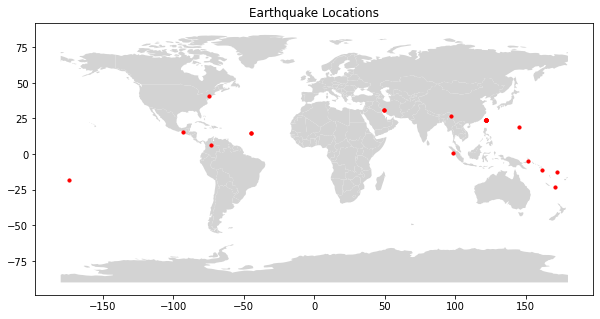

In [6]:

# Assuming `data` is your JSON object loaded from the USGS API response
# Convert earthquake data into a list of Shapely Point objects
points = [Point(earthquake['geometry']['coordinates'][0], earthquake['geometry']['coordinates'][1]) 
          for earthquake in data['features']]

# Create a GeoDataFrame from the points and set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdf = gpd.GeoDataFrame(geometry=points, crs='EPSG:4326')

# Create a simple base map (world map) - you can customize this as needed
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgrey')
gdf.plot(ax=ax, color='red', markersize=10)
plt.title('Earthquake Locations')
plt.show()

